In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
%matplotlib inline

import numpy as np
np.random.seed(1)

import random
from skimage import io
import cv2
from keras.preprocessing.image import img_to_array
from vis.utils import utils
from vis.visualization import visualize_cam,visualize_saliency

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications import VGG19
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import RMSprop, SGD

Using TensorFlow backend.


In [2]:
imagedir = "Dataset_4850"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.jpg'))  # assuming the images are stored as 'jpg'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.jpg'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:              CG	Number of images: 4850
Label: 1	Family:              PG	Number of images: 4850
Processing images ...
Images processed: 9700


In [4]:
X.shape

(9700, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base model (VGG19 convolutional layers)
img_shape = (224, 224, 3)                                                                                                                                               
model = Sequential()

# Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape=img_shape))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

# Block 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

# Block 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])       

In [7]:
vgg19weights = "vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
model.load_weights(vgg19weights, by_name=True)

In [8]:
filename = 'paper-vgg19features.npy'
if os.path.exists(filename):
    print("Loading VGG19 extracted features from %s ..." %(filename))
    vggfeatures = np.load(filename)
else:
    print("Extracting features from VGG19 convolutional layers ...")
    vggfeatures = model.predict(X)
    print("Saving VGG19 extracted features into %s ..." %(filename))
    np.save(filename, vggfeatures)

Loading VGG19 extracted features from paper-vgg19features.npy ...


In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [10]:
# Training top_model and saving min training loss weights
num_epochs=200
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='paper-top-weights-min_loss-mlp-vgg19-2layers-160neurons-relu-0.4dropout-Adam-200epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = vggfeatures[train_indices]
    Y_train = Y[train_indices]
    X_test = vggfeatures[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    top_model = Sequential() 
    top_model.add(Flatten(input_shape=model.output_shape[1:])) # input_shape=(7,7,512)                                                
    top_model.add(Dense(160, activation='relu', name='fc1'))
    top_model.add(Dropout(0.4))                
    top_model.add(Dense(160, activation='relu', name='fc2'))
    top_model.add(Dropout(0.4))              
    top_model.add(Dense(num_classes, activation='softmax', name='predictions'))                             
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=[checkpointer])
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 7760 samples, validate on 1940 samples
Epoch 1/200
7760/7760 [==============================] - 2s - loss: 5.4529 - acc: 0.4929 - val_loss: 4.8938 - val_acc: 0.6371
Epoch 2/200
7760/7760 [==============================] - 1s - loss: 4.7973 - acc: 0.6357 - val_loss: 3.6073 - val_acc: 0.7072
Epoch 3/200
7760/7760 [==============================] - 1s - loss: 3.5043 - acc: 0.7140 - val_loss: 1.8964 - val_acc: 0.7985
Epoch 4/200
7760/7760 [==============================] - 1s - loss: 2.4848 - acc: 0.7737 - val_loss: 1.8571 - val_acc: 0.8046
Epoch 5/200
7760/7760 [==============================] - 1s - loss: 2.3955 - acc: 0.7812 - val_loss: 1.5295 - val_acc: 0.8294
Epoch 6/200
7760/7760 [==============================] - 1s - loss: 1.9296 - acc: 0.8122 - val_loss: 1.6946 - val_acc: 0.8216
Epoch 7/200
7760/7760 [==============================] - 1s - loss: 1.7881 - acc: 0.8211 - val_loss: 1.5753 - val_acc: 0.8325
Epoch 8/200
7760/7760 [==============================] - 1s - loss: 1.

7760/7760 [==============================] - 1s - loss: 0.0941 - acc: 0.9459 - val_loss: 1.0147 - val_acc: 0.8670
Epoch 66/200
7760/7760 [==============================] - 1s - loss: 0.0931 - acc: 0.9470 - val_loss: 1.0132 - val_acc: 0.8675
Epoch 67/200
7760/7760 [==============================] - 1s - loss: 0.0874 - acc: 0.9477 - val_loss: 1.0133 - val_acc: 0.8680
Epoch 68/200
7760/7760 [==============================] - 1s - loss: 0.0877 - acc: 0.9465 - val_loss: 1.0179 - val_acc: 0.8696
Epoch 69/200
7760/7760 [==============================] - 1s - loss: 0.0917 - acc: 0.9494 - val_loss: 1.0243 - val_acc: 0.8691
Epoch 70/200
7760/7760 [==============================] - 1s - loss: 0.0828 - acc: 0.9496 - val_loss: 1.0251 - val_acc: 0.8706
Epoch 71/200
7760/7760 [==============================] - 1s - loss: 0.0860 - acc: 0.9478 - val_loss: 1.0157 - val_acc: 0.8696
Epoch 72/200
7760/7760 [==============================] - 1s - loss: 0.0830 - acc: 0.9503 - val_loss: 1.0073 - val_acc: 0.87

7760/7760 [==============================] - 1s - loss: 0.0611 - acc: 0.9613 - val_loss: 1.0769 - val_acc: 0.8794
Epoch 130/200
7760/7760 [==============================] - 1s - loss: 0.0614 - acc: 0.9616 - val_loss: 1.0702 - val_acc: 0.8789
Epoch 131/200
7760/7760 [==============================] - 1s - loss: 0.0669 - acc: 0.9598 - val_loss: 1.0635 - val_acc: 0.8794
Epoch 132/200
7760/7760 [==============================] - 1s - loss: 0.0656 - acc: 0.9584 - val_loss: 1.0597 - val_acc: 0.8799
Epoch 133/200
7760/7760 [==============================] - 1s - loss: 0.0610 - acc: 0.9622 - val_loss: 1.0590 - val_acc: 0.8820
Epoch 134/200
7760/7760 [==============================] - 1s - loss: 0.0641 - acc: 0.9608 - val_loss: 1.0538 - val_acc: 0.8814
Epoch 135/200
7760/7760 [==============================] - 1s - loss: 0.0631 - acc: 0.9615 - val_loss: 1.0524 - val_acc: 0.8820
Epoch 136/200
7760/7760 [==============================] - 1s - loss: 0.0621 - acc: 0.9610 - val_loss: 1.0542 - val_ac

7760/7760 [==============================] - 1s - loss: 0.0543 - acc: 0.9697 - val_loss: 1.1350 - val_acc: 0.8835
Epoch 194/200
7760/7760 [==============================] - 1s - loss: 0.0557 - acc: 0.9700 - val_loss: 1.1458 - val_acc: 0.8835
Epoch 195/200
7760/7760 [==============================] - 1s - loss: 0.0522 - acc: 0.9709 - val_loss: 1.1491 - val_acc: 0.8830
Epoch 196/200
7760/7760 [==============================] - 1s - loss: 0.0544 - acc: 0.9684 - val_loss: 1.1541 - val_acc: 0.8830
Epoch 197/200
7760/7760 [==============================] - 1s - loss: 0.0516 - acc: 0.9714 - val_loss: 1.1555 - val_acc: 0.8835
Epoch 198/200
7760/7760 [==============================] - 1s - loss: 0.0504 - acc: 0.9697 - val_loss: 1.1579 - val_acc: 0.8840
Epoch 199/200
7760/7760 [==============================] - 1s - loss: 0.0513 - acc: 0.9695 - val_loss: 1.1622 - val_acc: 0.8830
Epoch 200/200
7760/7760 [==============================] - 1s - loss: 0.0526 - acc: 0.9698 - val_loss: 1.1645 - val_ac

7760/7760 [==============================] - 1s - loss: 0.1355 - acc: 0.9461 - val_loss: 0.7860 - val_acc: 0.8613
Epoch 58/200
7760/7760 [==============================] - 1s - loss: 0.1275 - acc: 0.9485 - val_loss: 0.7886 - val_acc: 0.8649
Epoch 59/200
7760/7760 [==============================] - 1s - loss: 0.1334 - acc: 0.9457 - val_loss: 0.7917 - val_acc: 0.8639
Epoch 60/200
7760/7760 [==============================] - 1s - loss: 0.1201 - acc: 0.9476 - val_loss: 0.7971 - val_acc: 0.8644
Epoch 61/200
7760/7760 [==============================] - 1s - loss: 0.1269 - acc: 0.9490 - val_loss: 0.8064 - val_acc: 0.8670
Epoch 62/200
7760/7760 [==============================] - 1s - loss: 0.1182 - acc: 0.9478 - val_loss: 0.8189 - val_acc: 0.8665
Epoch 63/200
7760/7760 [==============================] - 1s - loss: 0.1154 - acc: 0.9536 - val_loss: 0.8370 - val_acc: 0.8665
Epoch 64/200
7760/7760 [==============================] - 1s - loss: 0.1176 - acc: 0.9508 - val_loss: 0.8455 - val_acc: 0.86

7760/7760 [==============================] - 1s - loss: 0.0688 - acc: 0.9682 - val_loss: 1.0397 - val_acc: 0.8742
Epoch 122/200
7760/7760 [==============================] - 1s - loss: 0.0640 - acc: 0.9692 - val_loss: 1.0419 - val_acc: 0.8742
Epoch 123/200
7760/7760 [==============================] - 1s - loss: 0.0653 - acc: 0.9688 - val_loss: 1.0449 - val_acc: 0.8727
Epoch 124/200
7760/7760 [==============================] - 1s - loss: 0.0672 - acc: 0.9669 - val_loss: 1.0491 - val_acc: 0.8727
Epoch 125/200
7760/7760 [==============================] - 1s - loss: 0.0666 - acc: 0.9686 - val_loss: 1.0563 - val_acc: 0.8737
Epoch 126/200
7760/7760 [==============================] - 1s - loss: 0.0675 - acc: 0.9675 - val_loss: 1.0651 - val_acc: 0.8753
Epoch 127/200
7760/7760 [==============================] - 1s - loss: 0.0678 - acc: 0.9686 - val_loss: 1.0731 - val_acc: 0.8747
Epoch 128/200
7760/7760 [==============================] - 1s - loss: 0.0672 - acc: 0.9683 - val_loss: 1.0760 - val_ac

7760/7760 [==============================] - 1s - loss: 0.0556 - acc: 0.9740 - val_loss: 1.1507 - val_acc: 0.8732
Epoch 186/200
7760/7760 [==============================] - 1s - loss: 0.0561 - acc: 0.9749 - val_loss: 1.1466 - val_acc: 0.8732
Epoch 187/200
7760/7760 [==============================] - 1s - loss: 0.0579 - acc: 0.9724 - val_loss: 1.1440 - val_acc: 0.8716
Epoch 188/200
7760/7760 [==============================] - 1s - loss: 0.0565 - acc: 0.9741 - val_loss: 1.1406 - val_acc: 0.8722
Epoch 189/200
7760/7760 [==============================] - 1s - loss: 0.0545 - acc: 0.9746 - val_loss: 1.1373 - val_acc: 0.8727
Epoch 190/200
7760/7760 [==============================] - 1s - loss: 0.0543 - acc: 0.9753 - val_loss: 1.1375 - val_acc: 0.8737
Epoch 191/200
7760/7760 [==============================] - 1s - loss: 0.0573 - acc: 0.9737 - val_loss: 1.1368 - val_acc: 0.8737
Epoch 192/200
7760/7760 [==============================] - 1s - loss: 0.0554 - acc: 0.9753 - val_loss: 1.1345 - val_ac

7760/7760 [==============================] - 1s - loss: 0.1279 - acc: 0.9278 - val_loss: 0.6746 - val_acc: 0.8784
Epoch 49/200
7760/7760 [==============================] - 1s - loss: 0.1293 - acc: 0.9262 - val_loss: 0.6837 - val_acc: 0.8773
Epoch 50/200
7760/7760 [==============================] - 1s - loss: 0.1275 - acc: 0.9293 - val_loss: 0.6885 - val_acc: 0.8768
Epoch 51/200
7760/7760 [==============================] - 1s - loss: 0.1195 - acc: 0.9286 - val_loss: 0.6974 - val_acc: 0.8773
Epoch 52/200
7760/7760 [==============================] - 1s - loss: 0.1188 - acc: 0.9282 - val_loss: 0.7037 - val_acc: 0.8773
Epoch 53/200
7760/7760 [==============================] - 1s - loss: 0.1183 - acc: 0.9300 - val_loss: 0.7114 - val_acc: 0.8768
Epoch 54/200
7760/7760 [==============================] - 1s - loss: 0.1132 - acc: 0.9323 - val_loss: 0.7150 - val_acc: 0.8763
Epoch 55/200
7760/7760 [==============================] - 1s - loss: 0.1124 - acc: 0.9308 - val_loss: 0.7150 - val_acc: 0.87

7760/7760 [==============================] - 1s - loss: 0.0705 - acc: 0.9549 - val_loss: 0.8635 - val_acc: 0.8814
Epoch 113/200
7760/7760 [==============================] - 1s - loss: 0.0721 - acc: 0.9557 - val_loss: 0.8629 - val_acc: 0.8814
Epoch 114/200
7760/7760 [==============================] - 1s - loss: 0.0713 - acc: 0.9536 - val_loss: 0.8632 - val_acc: 0.8825
Epoch 115/200
7760/7760 [==============================] - 1s - loss: 0.0746 - acc: 0.9536 - val_loss: 0.8629 - val_acc: 0.8840
Epoch 116/200
7760/7760 [==============================] - 1s - loss: 0.0726 - acc: 0.9535 - val_loss: 0.8638 - val_acc: 0.8856
Epoch 117/200
7760/7760 [==============================] - 1s - loss: 0.0743 - acc: 0.9550 - val_loss: 0.8637 - val_acc: 0.8856
Epoch 118/200
7760/7760 [==============================] - 1s - loss: 0.0711 - acc: 0.9558 - val_loss: 0.8676 - val_acc: 0.8840
Epoch 119/200
7760/7760 [==============================] - 1s - loss: 0.0709 - acc: 0.9546 - val_loss: 0.8738 - val_ac

7760/7760 [==============================] - 1s - loss: 0.0578 - acc: 0.9664 - val_loss: 0.9118 - val_acc: 0.8814
Epoch 177/200
7760/7760 [==============================] - 1s - loss: 0.0594 - acc: 0.9648 - val_loss: 0.9170 - val_acc: 0.8809
Epoch 178/200
7760/7760 [==============================] - 1s - loss: 0.0595 - acc: 0.9651 - val_loss: 0.9245 - val_acc: 0.8809
Epoch 179/200
7760/7760 [==============================] - 1s - loss: 0.0588 - acc: 0.9647 - val_loss: 0.9319 - val_acc: 0.8799
Epoch 180/200
7760/7760 [==============================] - 1s - loss: 0.0623 - acc: 0.9621 - val_loss: 0.9338 - val_acc: 0.8814
Epoch 181/200
7760/7760 [==============================] - 1s - loss: 0.0608 - acc: 0.9642 - val_loss: 0.9340 - val_acc: 0.8814
Epoch 182/200
7760/7760 [==============================] - 1s - loss: 0.0584 - acc: 0.9642 - val_loss: 0.9330 - val_acc: 0.8845
Epoch 183/200
7760/7760 [==============================] - 1s - loss: 0.0624 - acc: 0.9634 - val_loss: 0.9218 - val_ac

7760/7760 [==============================] - 1s - loss: 0.1577 - acc: 0.9122 - val_loss: 0.6880 - val_acc: 0.8505
Epoch 40/200
7760/7760 [==============================] - 1s - loss: 0.1548 - acc: 0.9171 - val_loss: 0.6965 - val_acc: 0.8500
Epoch 41/200
7760/7760 [==============================] - 1s - loss: 0.1382 - acc: 0.9197 - val_loss: 0.7058 - val_acc: 0.8521
Epoch 42/200
7760/7760 [==============================] - 1s - loss: 0.1407 - acc: 0.9200 - val_loss: 0.7188 - val_acc: 0.8541
Epoch 43/200
7760/7760 [==============================] - 1s - loss: 0.1396 - acc: 0.9236 - val_loss: 0.7329 - val_acc: 0.8557
Epoch 44/200
7760/7760 [==============================] - 1s - loss: 0.1368 - acc: 0.9214 - val_loss: 0.7440 - val_acc: 0.8536
Epoch 45/200
7760/7760 [==============================] - 1s - loss: 0.1347 - acc: 0.9206 - val_loss: 0.7529 - val_acc: 0.8510
Epoch 46/200
7760/7760 [==============================] - 1s - loss: 0.1288 - acc: 0.9267 - val_loss: 0.7629 - val_acc: 0.85

7760/7760 [==============================] - 1s - loss: 0.0668 - acc: 0.9615 - val_loss: 1.0135 - val_acc: 0.8747
Epoch 104/200
7760/7760 [==============================] - 1s - loss: 0.0637 - acc: 0.9646 - val_loss: 1.0170 - val_acc: 0.8753
Epoch 105/200
7760/7760 [==============================] - 1s - loss: 0.0584 - acc: 0.9643 - val_loss: 1.0207 - val_acc: 0.8758
Epoch 106/200
7760/7760 [==============================] - 1s - loss: 0.0615 - acc: 0.9642 - val_loss: 1.0167 - val_acc: 0.8763
Epoch 107/200
7760/7760 [==============================] - 1s - loss: 0.0620 - acc: 0.9647 - val_loss: 1.0144 - val_acc: 0.8753
Epoch 108/200
7760/7760 [==============================] - 1s - loss: 0.0629 - acc: 0.9656 - val_loss: 1.0127 - val_acc: 0.8753
Epoch 109/200
7760/7760 [==============================] - 1s - loss: 0.0602 - acc: 0.9665 - val_loss: 1.0108 - val_acc: 0.8753
Epoch 110/200
7760/7760 [==============================] - 1s - loss: 0.0603 - acc: 0.9652 - val_loss: 1.0087 - val_ac

7760/7760 [==============================] - 1s - loss: 0.0519 - acc: 0.9713 - val_loss: 1.0789 - val_acc: 0.8711
Epoch 168/200
7760/7760 [==============================] - 1s - loss: 0.0542 - acc: 0.9701 - val_loss: 1.0872 - val_acc: 0.8716
Epoch 169/200
7760/7760 [==============================] - 1s - loss: 0.0540 - acc: 0.9692 - val_loss: 1.0962 - val_acc: 0.8716
Epoch 170/200
7760/7760 [==============================] - 1s - loss: 0.0534 - acc: 0.9687 - val_loss: 1.0972 - val_acc: 0.8716
Epoch 171/200
7760/7760 [==============================] - 1s - loss: 0.0532 - acc: 0.9702 - val_loss: 1.0958 - val_acc: 0.8732
Epoch 172/200
7760/7760 [==============================] - 1s - loss: 0.0528 - acc: 0.9700 - val_loss: 1.0924 - val_acc: 0.8727
Epoch 173/200
7760/7760 [==============================] - 1s - loss: 0.0522 - acc: 0.9718 - val_loss: 1.0931 - val_acc: 0.8737
Epoch 174/200
7760/7760 [==============================] - 1s - loss: 0.0531 - acc: 0.9710 - val_loss: 1.0941 - val_ac

7760/7760 [==============================] - 1s - loss: 0.2332 - acc: 0.8916 - val_loss: 0.5893 - val_acc: 0.8464
Epoch 31/200
7760/7760 [==============================] - 1s - loss: 0.2273 - acc: 0.8982 - val_loss: 0.6136 - val_acc: 0.8474
Epoch 32/200
7760/7760 [==============================] - 1s - loss: 0.2184 - acc: 0.8992 - val_loss: 0.6333 - val_acc: 0.8474
Epoch 33/200
7760/7760 [==============================] - 1s - loss: 0.2052 - acc: 0.9036 - val_loss: 0.6534 - val_acc: 0.8469
Epoch 34/200
7760/7760 [==============================] - 1s - loss: 0.1957 - acc: 0.9067 - val_loss: 0.6685 - val_acc: 0.8479
Epoch 35/200
7760/7760 [==============================] - 1s - loss: 0.1885 - acc: 0.9086 - val_loss: 0.6776 - val_acc: 0.8485
Epoch 36/200
7760/7760 [==============================] - 1s - loss: 0.1912 - acc: 0.9088 - val_loss: 0.6909 - val_acc: 0.8515
Epoch 37/200
7760/7760 [==============================] - 1s - loss: 0.1729 - acc: 0.9175 - val_loss: 0.7059 - val_acc: 0.85

7760/7760 [==============================] - 1s - loss: 0.0785 - acc: 0.9549 - val_loss: 1.0183 - val_acc: 0.8722
Epoch 95/200
7760/7760 [==============================] - 1s - loss: 0.0814 - acc: 0.9571 - val_loss: 1.0154 - val_acc: 0.8716
Epoch 96/200
7760/7760 [==============================] - 1s - loss: 0.0723 - acc: 0.9591 - val_loss: 1.0166 - val_acc: 0.8722
Epoch 97/200
7760/7760 [==============================] - 1s - loss: 0.0792 - acc: 0.9540 - val_loss: 1.0144 - val_acc: 0.8716
Epoch 98/200
7760/7760 [==============================] - 1s - loss: 0.0770 - acc: 0.9544 - val_loss: 1.0004 - val_acc: 0.8691
Epoch 99/200
7760/7760 [==============================] - 1s - loss: 0.0715 - acc: 0.9584 - val_loss: 0.9924 - val_acc: 0.8696
Epoch 100/200
7760/7760 [==============================] - 1s - loss: 0.0758 - acc: 0.9564 - val_loss: 0.9894 - val_acc: 0.8696
Epoch 101/200
7760/7760 [==============================] - 1s - loss: 0.0699 - acc: 0.9601 - val_loss: 0.9894 - val_acc: 0.

7760/7760 [==============================] - 1s - loss: 0.0629 - acc: 0.9617 - val_loss: 1.0743 - val_acc: 0.8706
Epoch 159/200
7760/7760 [==============================] - 1s - loss: 0.0649 - acc: 0.9629 - val_loss: 1.0706 - val_acc: 0.8711
Epoch 160/200
7760/7760 [==============================] - 1s - loss: 0.0591 - acc: 0.9674 - val_loss: 1.0680 - val_acc: 0.8701
Epoch 161/200
7760/7760 [==============================] - 1s - loss: 0.0597 - acc: 0.9659 - val_loss: 1.0662 - val_acc: 0.8706
Epoch 162/200
7760/7760 [==============================] - 1s - loss: 0.0604 - acc: 0.9633 - val_loss: 1.0632 - val_acc: 0.8716
Epoch 163/200
7760/7760 [==============================] - 1s - loss: 0.0604 - acc: 0.9634 - val_loss: 1.0587 - val_acc: 0.8722
Epoch 164/200
7760/7760 [==============================] - 1s - loss: 0.0592 - acc: 0.9634 - val_loss: 1.0555 - val_acc: 0.8727
Epoch 165/200
7760/7760 [==============================] - 1s - loss: 0.0605 - acc: 0.9665 - val_loss: 1.0528 - val_ac

In [11]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.8772


In [12]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [13]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

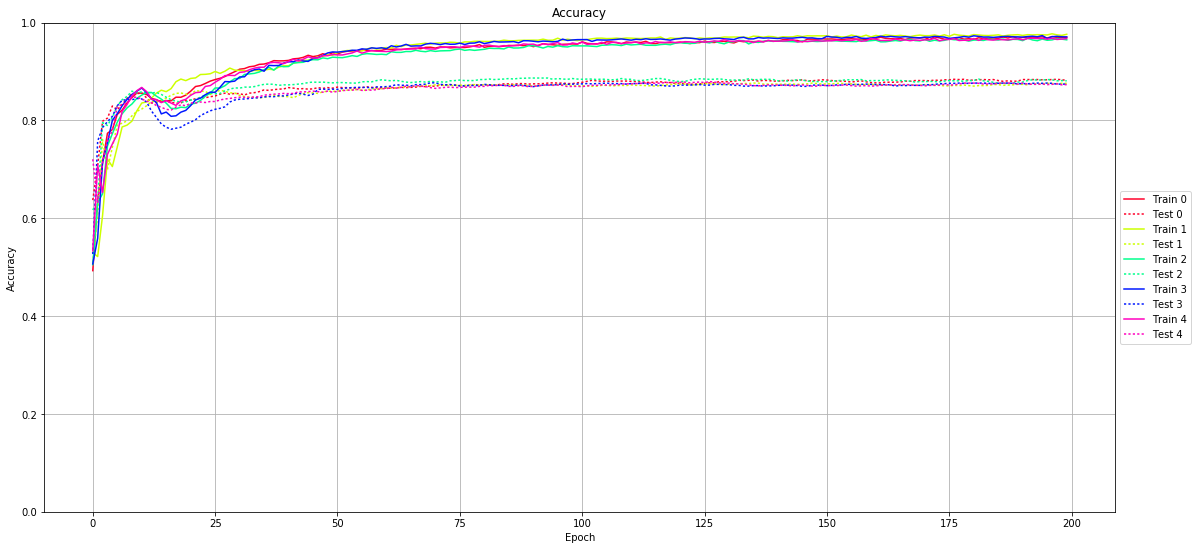

In [14]:
plot_acc(history)

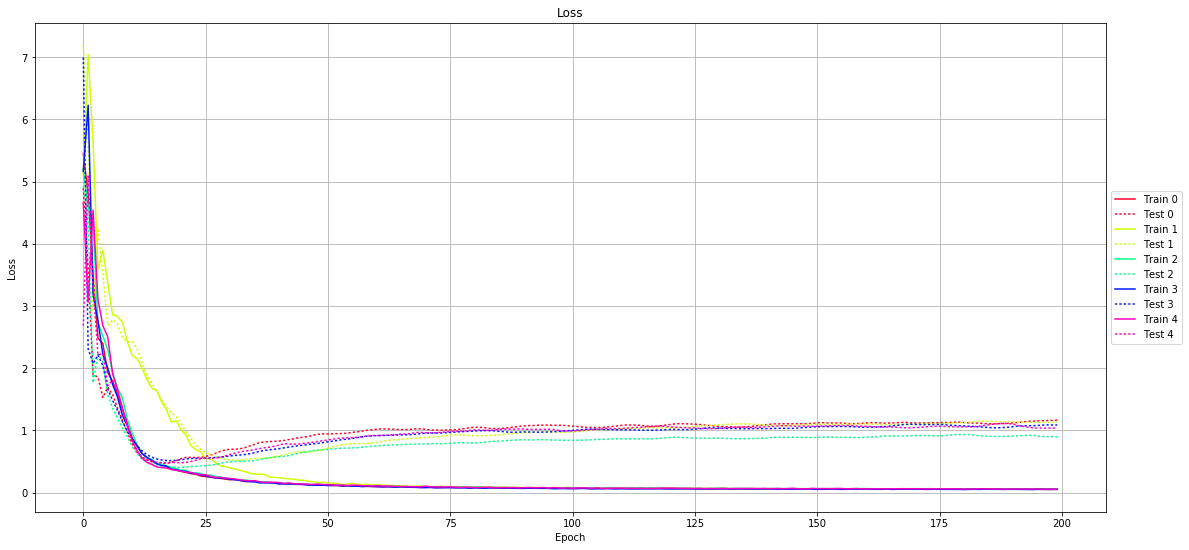

In [15]:
plot_loss(history)

In [16]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


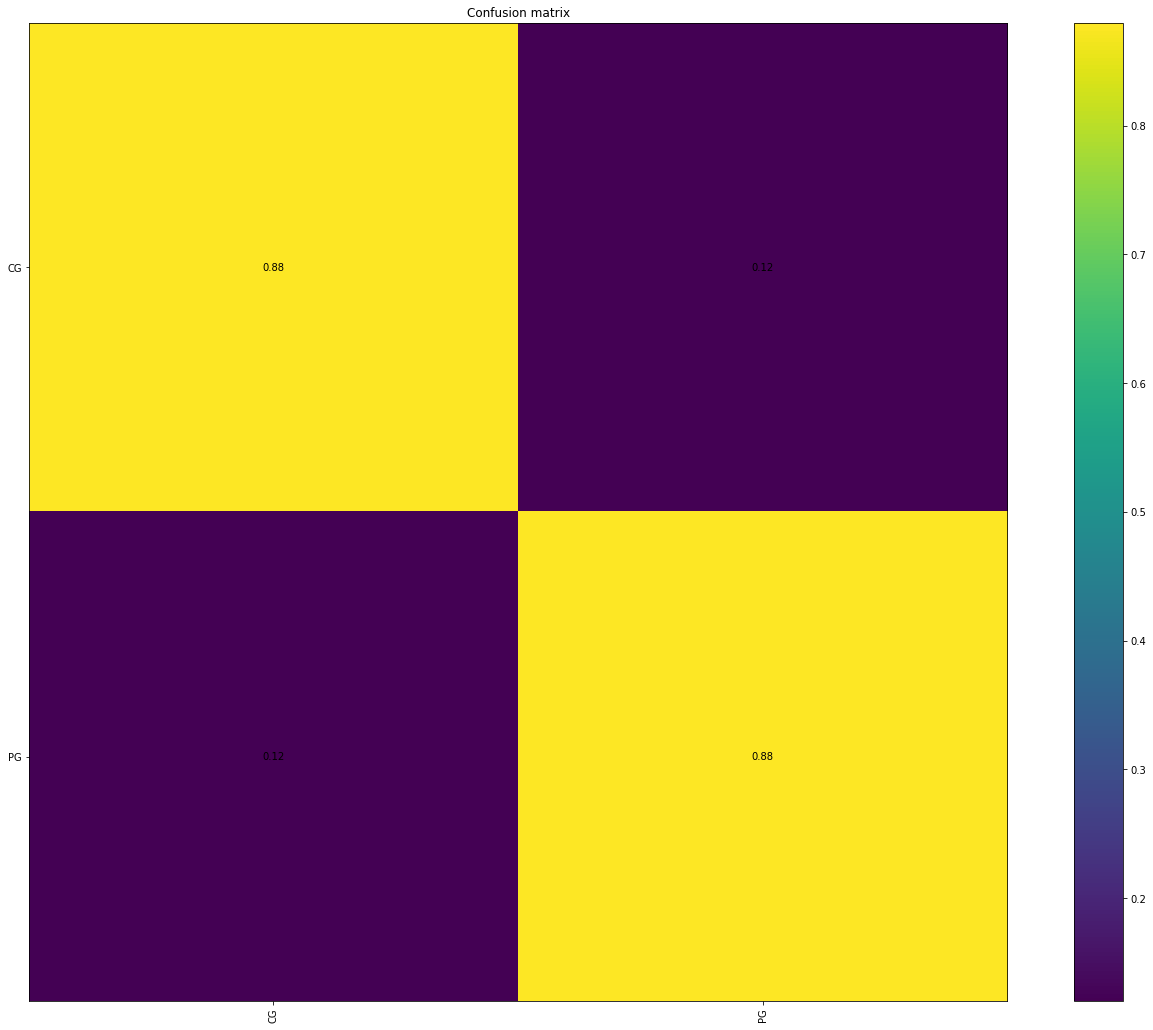

In [17]:
print("Plotting the confusion matrix")
conf_mat = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()

In [18]:
# Stacking top model (fc and softmax layers)
model.add(Flatten())                                                
model.add(Dense(160, activation='relu', name='fc1'))
model.add(Dropout(0.4))                
model.add(Dense(160, activation='relu', name='fc2'))
model.add(Dropout(0.4))              
model.add(Dense(num_classes, activation='softmax', name='predictions'))                             

In [19]:
top_weigths = "paper-top-weights-min_loss-mlp-vgg19-2layers-160neurons-relu-0.4dropout-Adam-200epochs.h5"
model.load_weights(top_weigths, by_name=True)

In [20]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# The name of the layer we want to visualize
layer_name = 'predictions'
layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_name][0]

Class: CG
4850
Image: ['npower_AUTO_nPower_Xmachinea_04.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['3dtotal_1547_1.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['artlantis_1256232412.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['3dtotal_1996.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['artlantis_1239040525.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['3dcommunity_Resize1.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['artlantis_1260833898.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['3dtotal_383.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['artlantis_1237463249.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['3dtotal_2251.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['artlantis_web_1271346020.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['3dtotal_1315.jpg'] - Class: ['CG'] - Pred: 1 (PG)
Image: ['artlantis_1242558692.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['3dcommunity_vasu_.in_new_09.jpg'] - Class: ['CG'] - Pred: 0 (CG)
Image: ['3dcommunity_environment43-small.jpg'] - Class: ['CG'] - 

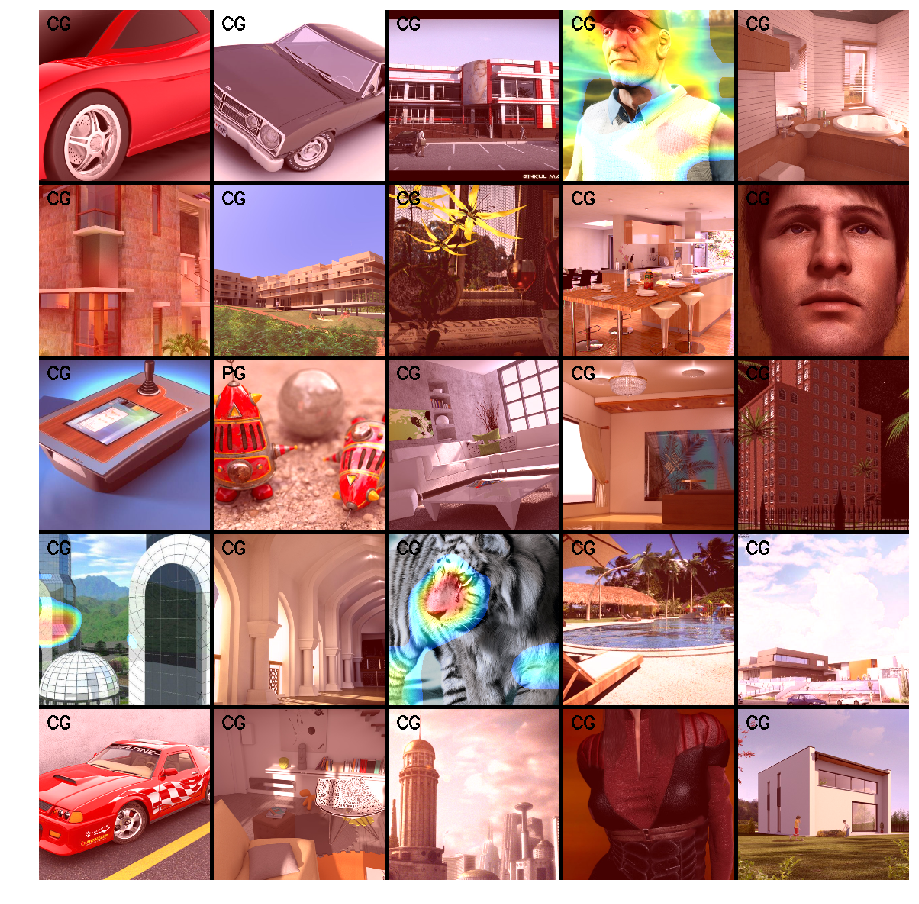

Class: PG
4850
Image: ['freeFoto_1225_06_32_prev.jpg'] - Class: ['PG'] - Pred: 1 (PG)
Image: ['picsNTrails_IMG_7887.jpg'] - Class: ['PG'] - Pred: 1 (PG)
Image: ['freeFoto_15_30_33_prev.jpg'] - Class: ['PG'] - Pred: 1 (PG)
Image: ['picsNTrails_IMG_9753.jpg'] - Class: ['PG'] - Pred: 1 (PG)
Image: ['freeFoto_35_08_16_prev.jpg'] - Class: ['PG'] - Pred: 0 (CG)
Image: ['picsNTrails_IMG_8382.jpg'] - Class: ['PG'] - Pred: 1 (PG)
Image: ['picsNTrails_IMG_8411.jpg'] - Class: ['PG'] - Pred: 1 (PG)
Image: ['picsNTrails_IMG_6782.jpg'] - Class: ['PG'] - Pred: 1 (PG)
Image: ['freeFoto_1303_01_62_prev.jpg'] - Class: ['PG'] - Pred: 1 (PG)
Image: ['pdPhoto_canada_5_bg_061904.jpg'] - Class: ['PG'] - Pred: 1 (PG)
Image: ['picsNTrails_IMG_7429.jpg'] - Class: ['PG'] - Pred: 1 (PG)
Image: ['picsNTrails_IMG_2340.jpg'] - Class: ['PG'] - Pred: 1 (PG)
Image: ['picsNTrails_IMG_6634.jpg'] - Class: ['PG'] - Pred: 1 (PG)
Image: ['pdPhoto_penny_20101231_bg_0240.jpg'] - Class: ['PG'] - Pred: 0 (CG)
Image: ['picsNTrail

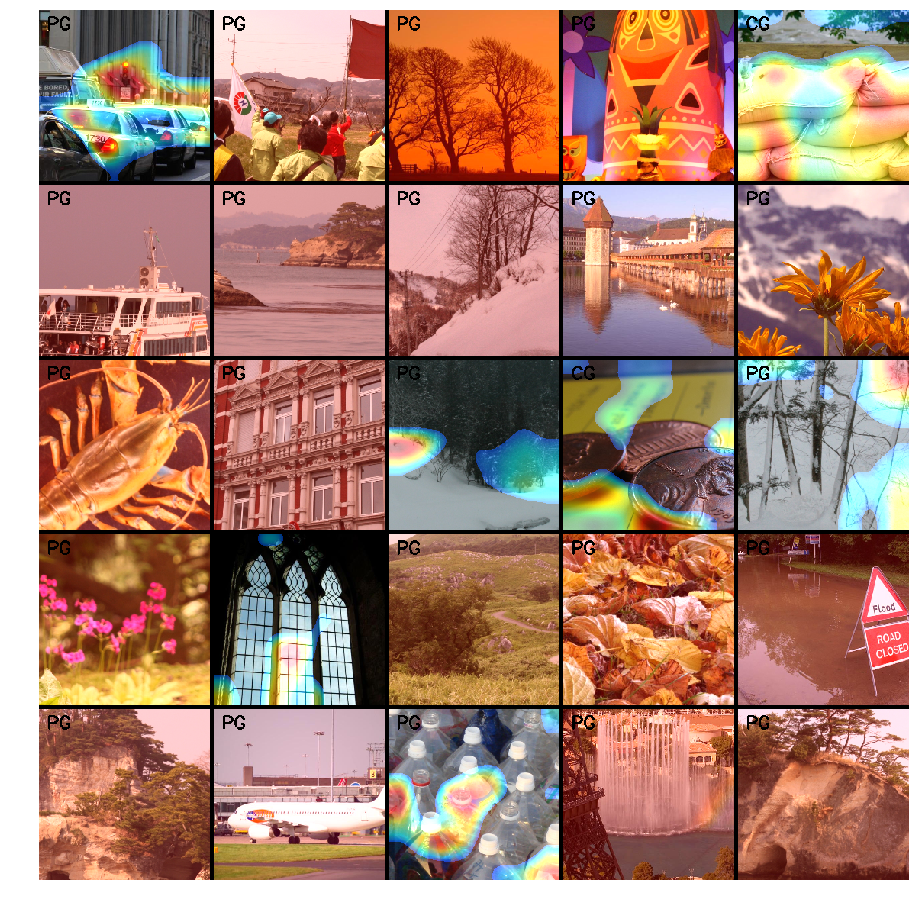

In [22]:
for fam in list_fams:
    print("Class: %s" %(fam))
    fam_samples = [name for name in list_paths if fam in name.split('/')[-2:-1]]
    print len(fam_samples)
    image_paths = random.sample(fam_samples, 25)
    
    heatmaps = []
    for path in image_paths:
        # Predict the corresponding class for use in `visualize_cam`.
        seed_img = utils.load_img(path, target_size=(224, 224))
        pred_class = np.argmax(model.predict(np.array([img_to_array(seed_img)])))
        print("Image: %s - Class: %s - Pred: %d (%s)" %(path.split('/')[-1:],path.split('/')[-2:-1],pred_class,list_fams[pred_class]))

        # Here we are asking it to show attention such that prob of `pred_class` is maximized.
        heatmap = visualize_cam(model, layer_idx, [pred_class], seed_img, text=list_fams[pred_class])
        heatmaps.append(heatmap)
        
    img_data = cv2.cvtColor(utils.stitch_images(heatmaps), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(16, 16))
    plt.axis('off')
    plt.imshow(img_data)
    plt.show()        